In [1]:
import coolingFunction

In [2]:
import copy
import numpy as np
import h5py
import scipy
import scipy.special
import sys
import verdict
import os
import tqdm
import unyt

In [3]:
import kalepy as kale

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import matplotlib.gridspec as gridspec
import matplotlib.transforms
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [6]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [7]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

In [8]:
import trove

# Load Data

In [9]:
pm = dict(
    snum = 600,
    tables_dir = '/work/03057/zhafen/CoolingTables/',
    study_duplicates = False,
    ahf_index = 600,
    
    # If we want to ensure some minimum number of snapshots in the galaxy after accreting
    # (remember to account for the last 10 snapshots with small dt)
    minInd = 0,
    
    # For the fancy scatter plot we're visualizing.
    variable_alpha = True,
)

In [10]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    variation = 'm12i_md',
    **pm
)

In [11]:
# Used so often it's nice to not enclose
snum = pm['snum']
ind = pm['ahf_index'] - snum

In [12]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['data_dir'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

In [13]:
w.retrieve_halo_data()

In [14]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{12} M_\odot$, z=0.0


In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [16]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

# Data Pre-Processing

## Calculate $\theta$
Also called $\phi$...

In [17]:
tot_momentum_fp = os.path.join( pm['processed_data_dir'], 'tot_momentums.hdf5' )
tot_ang_momentum = verdict.Dict.from_hdf5( tot_momentum_fp )[pm['variation']]['snum{:03d}'.format( snum )]

In [18]:
w.calc_abs_phi( normal_vector=tot_ang_momentum )

## Calculate mass deposition

In [19]:
delta_m = w.get_data( 'M' )[:,:-1] - w.get_data( 'M' )[:,1:]
deposited_m = np.ma.masked_array( delta_m, delta_m<0 ).sum( axis=1 ).data

# Analysis

In [20]:
# Setup axes
t_window = 1.
t = w.get_data( 'time' )
x_range = [ t[ind] - t_window, t[ind] ]

In [21]:
t_snaps = t[( t > x_range[0] ) & ( t < x_range[1] )][::-1]

In [22]:
n_snaps = t_snaps.size

In [23]:
dt = t_snaps[1:] - t_snaps[:-1]

In [24]:
t_bins = np.zeros( ( t_snaps.size + 1, ) )
t_bins[1:-1] = t_snaps[:-1] + dt / 2.
t_bins[0] = t_snaps[0] - dt[0] / 2.
t_bins[-1] = t_snaps[-1] + dt[-1] / 2.

In [25]:
   
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )

# Median and interval stats
logT = np.log10( w.get_selected_data( 'T', compress=False ) )#[:,ind:ind+n_snaps+1]
R = w.get_selected_data( 'R', compress=False )#[:,ind:ind+n_snaps+1]
L = w.get_selected_data( 'Lmag', compress=False )#[:,ind:ind+n_snaps+1]
M = w.get_selected_data( 'M', compress=False )#[:,ind:ind+n_snaps+1]

logT_med = np.nanmedian( logT, axis=0 )
R_med = np.nanmedian( R, axis=0 )

logT_low = np.nanpercentile( logT, 16, axis=0 )
logT_high = np.nanpercentile( logT, 84, axis=0 )

R_low = np.nanpercentile( R, 16, axis=0 )
R_high = np.nanpercentile( R, 84, axis=0 )

inds = w.get_data( 't_1e5_inds' )

R_at_Tcool = np.array( [ R[i, ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]
M_at_Tcool = np.array( [ M[i, ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]
L_at_Tcool = np.array( [ L[i, ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]
R_rgal_at_Tcool = np.array( [ R[i, ind]/w.r_gal[ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]

t_at_Tcool = np.array( [ t[ind] for ind in inds ] )[inds >= pm['minInd']]


100%|██████████| 45846/45846 [00:03<00:00, 12456.73it/s]


## Store for Later Use

In [26]:
data_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )

In [27]:
try:
    data = verdict.Dict.from_hdf5( data_fp )
except OSError:
    data = verdict.Dict({})

In [28]:
# Store R for later use
r_vir = w.r_vir[snum]
r_points, r_pdf = kale.density(
    R_at_Tcool[np.invert(np.isnan(R_at_Tcool))],
    points = np.linspace( 0., r_vir, 512 ),
    probability = True,
    reflect = [ 0., None ],
)

In [29]:
data_to_store = {
    'points': r_points,
    'pdf': r_pdf,
    'median': np.nanmedian( R_at_Tcool ),
    '16th_percentile': np.nanpercentile( R_at_Tcool, 16 ),
    '84th_percentile': np.nanpercentile( R_at_Tcool, 84 ),
}

In [30]:
# Store radius for later use
if not 'R1e5K' in data.keys():
    data['R1e5K'] = {}
for key, item in data_to_store.items():
    if key not in data['R1e5K']:
        data['R1e5K'][key] = {}
    data['R1e5K'][key][pm['variation']] = item

In [31]:
# Store R for later use
r_vir = w.r_vir[snum]
r_points, r_pdf = kale.density(
    R_rgal_at_Tcool[np.invert(np.isnan(R_rgal_at_Tcool))],
    points = np.linspace( 0., r_vir / w.r_gal[0], 512 ),
    probability = True,
    reflect = [ 0., None ],
)

In [32]:
data_to_store = {
    'points': r_points,
    'pdf': r_pdf,
    'median': np.nanmedian( R_rgal_at_Tcool ),
    '16th_percentile': np.nanpercentile( R_rgal_at_Tcool, 16 ),
    '84th_percentile': np.nanpercentile( R_rgal_at_Tcool, 84 ),
}

In [33]:
# Store radius relative to galaxy radius for later use
if not 'R1e5K_rgal' in data.keys():
    data['R1e5K_rgal'] = {}
for key, item in data_to_store.items():
    if key not in data['R1e5K_rgal']:
        data['R1e5K_rgal'][key] = {}
    data['R1e5K_rgal'][key][pm['variation']] = item

In [34]:
# Store number of particles tracked
if not 'n_tracked' in data.keys():
    data['n_tracked'] = {}
data['n_tracked'][pm['variation']] = w.n_particles

In [35]:
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

Stored summary data at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/data/summary.hdf5


## Accretion Tracks and $R_{\rm 10^5K}$ Distribution

In [36]:
dt_before = -1.
dt_after = 0.5
color_dt = 0.2
n_particles = 5
x_lim = np.array( [ 0, 105 ] )
y_lim = np.array( [ 5e3, 5e6 ] )
y2_lim = np.array( [ 1, 1e2 ] )

Median R_at_Tcool = 0.0599 Rvir


File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/tracks/tracks_m12i_md.pdf


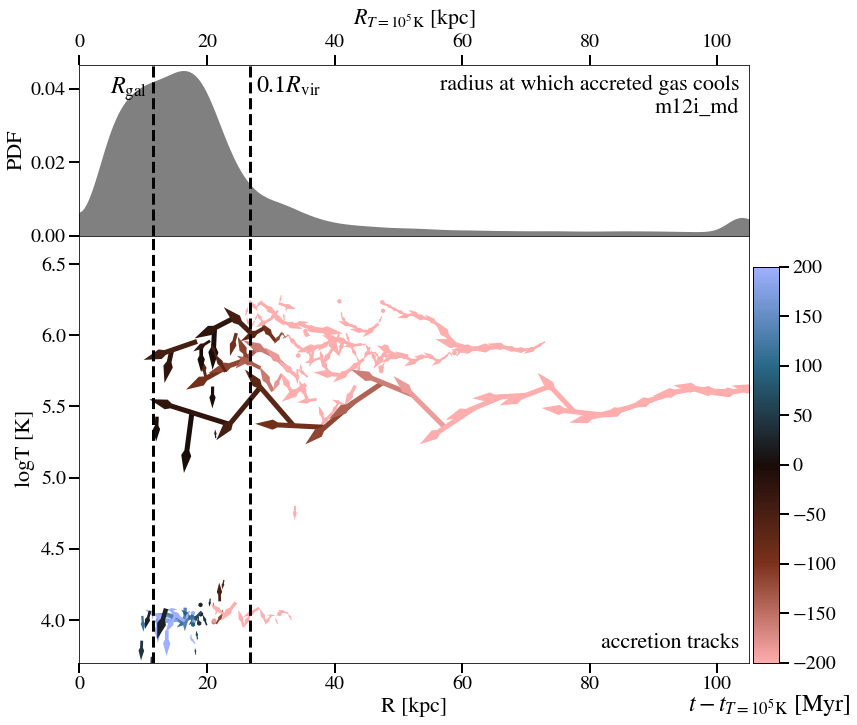

In [37]:
%matplotlib inline

# Load sim data

w.data_masker.clear_masks()

# Only include particles that have never left the main galaxy
w.data_masker.mask_data( 'n_out', -1, 1 )

np.random.seed( 4 )

fig = plt.figure( figsize=(12, 11), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec(7, 1)
gs.update( hspace=0.001 )

ax1 = plt.subplot(gs[:2,0])

r_for_hist = copy.copy( R_at_Tcool )
r_for_hist[r_for_hist>x_lim[1]] = x_lim[1]*.99
bins = np.linspace( x_lim[0], x_lim[1], 256 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

r_points, r_pdf = kale.density(
    r_for_hist[np.invert(np.isnan(r_for_hist))],
    points = centers,
    probability = True,
    reflect = [ 0., None ],
)
ax1.fill_between(
    r_points,
    r_pdf,
    color = '0.5',
    linewidth = 5,
)

# n, bins, patches = ax1.hist(
#     r_for_hist,
#     bins = ,
#     color = '0.5',
#     density = True,
# )

print( 'Median R_at_Tcool = {:.3g} Rvir'.format( np.nanmedian( R_at_Tcool ) / r_vir ) )

# Don't do the below, because it's so far out that it's not visible
# Create plot for volume filling distribution
#     n_rand = int( 1e5 )
#     data_coords = np.random.uniform( -r_vir, r_vir, (3, n_rand ) )
#     data_r = np.sqrt( ( data_coords ** 2. ).sum( axis=0 ) )
#     filtered_data_r = data_r[data_r<r_vir]
#     ax1.hist(
#         filtered_data_r,
#         bins = bins,
#         color = 'k',
#         density = True,
#         histtype = 'step',
#         linewidth = 3,
#         linestyle = '--',
#     )

# ax.axvline(
#     np.median( R_at_Tcool ),
#     color = 'k',
# )

# ax1.axvline(
#     w.r_gal[0],
#     color = 'k',
#     linestyle = '--',
#     linewidth = 3,
# )

ax1.set_xlim( x_lim )
ax1.set_ylim( 0, r_pdf.max()*1.05 )

ax1.set_xlabel( r'$R_{T=10^5{\rm K}}$ [kpc]', fontsize=22, labelpad=10 )
ax1.xaxis.set_label_position( 'top' )
ax1.set_ylabel( 'PDF', fontsize=22, )

ax1.tick_params( axis='x', top=True, labeltop=True, bottom=False, labelbottom=False )
# ax1.tick_params( axis='y', left=False, labelleft=False, )

ax1.annotate(
    text='radius at which accreted gas cools\n{}'.format( pm['variation'] ),
    xy=(1,1),
    xycoords='axes fraction',
    xytext=(-10,-10),
    textcoords='offset points',
    ha = 'right',
    va = 'top',
    fontsize = 22,
)


### FLOW PLOT ####

ax2 = plt.subplot(gs[2:,0])
ax3 = ax

# Choose particles
particle_inds = np.random.choice( np.arange( w.n_particles ), size=n_particles, replace=False )

# Get the time at the phase
t_min_t_cool = ( t[:,np.newaxis] - t[inds] ).transpose()
w.data['t_rel_t1e5'] = t_min_t_cool

# Get positions in r-T space and color
valid_value = ( t_min_t_cool < dt_after ) & ( t_min_t_cool > dt_before )
valid_value = valid_value & ( w.get_data( 'n_out' ) == 0 )
valid_value_inds = valid_value[particle_inds]
r_vecs_all = w.get_data( 'R' )[particle_inds]
T_vecs_all = w.get_data( 'T' )[particle_inds]
K_vecs_all = w.get_data( 'entropy' )[particle_inds ]

# Plot quivers for each particles
for k, particle_ind in enumerate( particle_inds ):

    # Format for quiver
    r_vecs = r_vecs_all[k][valid_value_inds[k]]
    T_vecs = np.log10( T_vecs_all[k][valid_value_inds[k]] )
    K_vecs = np.log10( K_vecs_all[k][valid_value_inds[k]] )
    x = r_vecs[1:]
    y = T_vecs[1:]
    y2 = K_vecs[1:]
    dx = r_vecs[:-1] - r_vecs[1:]
    dy = T_vecs[:-1] - T_vecs[1:]
    dy2 = K_vecs[:-1] - K_vecs[1:]
    angles_deg = np.arctan2( dy, dx ) * 180. / np.pi
    C = t_min_t_cool[particle_inds][k,valid_value_inds[k]][1:] * 1e3

    # Plot quiver
    quiver = ax2.quiver(
        x, y,
        dx, dy,
        C,
        angles = 'xy',
        units = 'y',
        scale = 10,
        minshaft = 2,
        headwidth = 2,
        headlength = 3.5,
#             color = 'red',
        cmap = palettable.scientific.diverging.Berlin_5_r.mpl_colormap,
        norm = plt.Normalize( -color_dt*1e3, color_dt*1e3 ),
    )
    plotting.add_colorbar(
        fig,
#             ax2,
        quiver,
        ax_location = [0.905, 0.125, 0.03, 0.5],
#             method = 'ax',
    )

#     w_plotter.plot_streamlines(
#         ax = ax2,
#         x_key = 'R',
#         y_key = 'logT',
#         start_ind = ind,
#         end_ind = 'time_based',
#         t_end = 5.,
#         sample_inds = particle_inds,
#         sample_selected_interval = False,
# #         x_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
# #         y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
#         color = 'black',
#         fade_color = 'black',
#         min_fade_linewidth = 0.5,
#     #     fade_streamlines = False,
#     #     line_features = gas_to_star_line_features,
#         linewidth = 1,
#         x_label = 'R (kpc)',
#         y_label = 'logT (K)',
#     #     y_scale = 'log',
#         x_range = [ 0, 100. ],
#         y_range = [ 3.5, 6.9 ],
#     #     y_floor = 10.**3.8,
#     )

# Plot reference entropy lines
r = w.get_data( 'R' )
at_border = ( r < 1.1 * x_lim[1] ) & ( r > 0.9 * x_lim[1] ) & valid_value
k_at_border = w.get_data( 'entropy' )[at_border]
med_k_at_border = np.nanmedian( k_at_border )
a_vals = [ 0, 1, 2 ]
r_arr = np.linspace( x_lim[0], x_lim[1], 256 )
k_arrs = [ med_k_at_border * ( r_arr / x_lim[1] )**a for a in a_vals ]
for m, k_arr in enumerate( k_arrs ):
    ax3.plot(
        r_arr,
        np.log10( k_arr ),
        color = '0.25',
        linewidth = 1.5,
#             linestyle = '--',
    )
    ax3.annotate(
        text = r'$\propto r^{' + str( a_vals[m] ) + r'}$',
        xy = ( r_arr[100], np.log10( k_arr[100] ) ),
        xycoords = 'data',
        xytext = ( 0, 0 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'bottom',
        fontsize = 24,
        color = '0.25',
    )

# # Time
# ax.plot(
#     R_med,
#     logT_med,
#     linewidth = 3,
#     color = 'b',
# )
# ax.fill_between(
#     R_med,
#     logT_low,
#     logT_high,
#     color = 'b',
#     alpha = 0.25,
# )

for ax_k in [ ax2, ax3 ]:
    ax_k.annotate(
        text = 'accretion tracks',
        xy=(1,0),
        xycoords='axes fraction',
        xytext=(-10,10),
        textcoords='offset points',
        ha = 'right',
        va = 'bottom',
        fontsize = 22,
    )

t_label = ax2.annotate(
    text = r'$t - t_{T=10^5 {\rm K}}$ [Myr]',
    xy = ( 1, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -30 ),
    textcoords = 'offset points',
    ha = 'center',
    va = 'top',
    fontsize = 24,
)

# Radius lines
for ax_k in [ ax1, ax2, ax3 ]:
    ax_k.axvline(
        0.1 * r_vir,
        color = 'k',
        linestyle = '--',
        linewidth = 3,
    )
#     ax_k.axvline(
#         r_vir,
#         color = 'k',
#         linestyle = '--',
#         linewidth = 3,
#     )
    ax_k.axvline(
        w.r_gal[ind],
        color = 'k',
        linestyle = '--',
        linewidth = 3,
    )
    if ax_k.is_first_row():
        trans = matplotlib.transforms.blended_transform_factory( ax_k.transData, ax_k.transAxes )
        ax_k.annotate(
            text = r'$0.1 R_{\rm vir}$',
            xy = ( 0.1 * r_vir, 1.0 ),
            xycoords = trans,
            xytext = ( 6, -10 ),
            textcoords = 'offset points',
            ha = 'left',
            va = 'top',
            fontsize = 24,
        )
        ax_k.annotate(
            text = r'$ R_{\rm gal}$',
            xy = ( w.r_gal[ind], 1.0 ),
            xycoords = trans,
            xytext = ( -6, -10 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 24,
        )

# Remove bottom ticks on middle axis
#     ax2.tick_params( axis='x', bottom=False, labelbottom=False )

ax2.set_xlim( x_lim )
ax2.set_ylim( np.log10( y_lim ) )
ax2.set_ylabel( '$\log$T [K]', fontsize=22 )
ax3.set_xlim( x_lim )
ax3.set_ylim( np.log10( y2_lim) )
ax2.set_xlabel( 'R [kpc]', fontsize=22 )
ax3.set_ylabel( r'$\log$K [Kev cm$^2$]', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'tracks' ),
    save_file = 'tracks_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)


## Angular Distribution

In [38]:
bins = np.linspace( -1., 1., 128 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

In [39]:
t_t1e5_centers = np.array([ -0.15, -0.06, -0.03, 0., 0.03, 0.06, 0.15, ])

In [40]:
def calc_sph_harm_moment( l, m, phi, masses, radii ):
    
    prefactor = np.sqrt( 4. * np.pi / (2. * l + 1) )
    ylm = scipy.special.sph_harm( m, l, 0., phi ).real
    to_sum = masses * radii**l * ylm
    
    return prefactor * to_sum.sum()

In [41]:
# Get the time at the phase
t_t1e5 = ( t[:,np.newaxis] - t[inds] ).transpose()
t_t1e5_flat = t_t1e5.flatten()
t_post_inds = np.argmin( np.abs( t_t1e5 - 0.150 ), axis=1 )
t_pre_inds = np.argmin( np.abs( t_t1e5 + 0.150 ), axis=1 )
insufficient_time_after = t_post_inds == 0
insufficient_time_after_mask = np.tile( insufficient_time_after, ( w.n_snaps, 1 ) ).transpose()

In [42]:
# Mask Data
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )
w.data_masker.mask_data( 'insufficient_time_after', custom_mask=insufficient_time_after_mask,  )

In [43]:
# Get data
phi = w.get_selected_data( 'Phi', compress=False ).flatten()
r_scale = np.full( w.n_snaps, np.nan )
r_scale[:w.r_gal.size] = w.r_gal
radii = ( w.get_selected_data( 'R', compress=False ) / r_scale ).flatten()
masses = w.get_selected_data( 'M', compress=False ).flatten()

In [44]:
# Get distributions
cosphi_dists = []
cosphi_pdfs = []
cosphi_16ths = []
cosphi_84ths = []
cosphi_stds = []
q20 = []
q33 = []
dt = t_t1e5_centers[1] - t_t1e5_centers[0]
for i, center in enumerate( tqdm.tqdm( t_t1e5_centers ) ):
    bin_low = center - dt / 2.
    bin_high = center + dt / 2.
    in_bin = ( t_t1e5_flat > bin_low ) & ( t_t1e5_flat < bin_high )
    
    phi_arr = phi[in_bin]
    phi_arr_rad = phi_arr * np.pi / 180.
    cosphi_arr = np.cos( phi_arr_rad )
    cosphi_points, cosphi_pdf = kale.density(
        cosphi_arr[np.invert(np.isnan(cosphi_arr))],
        points = centers,
        probability = True,
        reflect = [ -1., 1. ],
    )
    cosphi_hist, cosphi_bins = np.histogram(
        cosphi_arr[np.invert(np.isnan(cosphi_arr))],
        bins = bins,
        density = True,
    )
    cosphi_pdfs.append( cosphi_pdf )
    cosphi_dists.append( cosphi_hist )
    
    cosphi_arr_comp = cosphi_arr.compressed()
    cosphi_16ths.append( np.nanpercentile( cosphi_arr_comp, 16 ) )
    cosphi_84ths.append( np.nanpercentile( cosphi_arr_comp, 84. ) )
    cosphi_stds.append( np.nanstd( cosphi_arr_comp ) )
    
    masked = np.invert( radii.mask ) & in_bin
    q20_i = calc_sph_harm_moment(
        2,
        0,
        phi[masked].compressed(),
        masses[masked].compressed(),
        radii[masked].compressed()
    )
    q20.append( q20_i )
    q33_i = calc_sph_harm_moment(
        3,
        3,
        phi[masked].compressed(),
        masses[masked].compressed(),
        radii[masked].compressed()
    )
    q33.append( q33_i )

100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


In [45]:
labeled_is = np.arange( len( t_t1e5_centers ) )

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/ang_dist_evolution/theta_vs_t_m12i_md.pdf


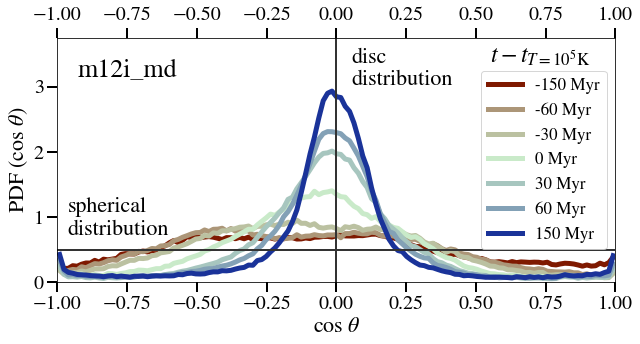

In [46]:
fig = plt.figure( figsize=(10, 4.5 ), facecolor='w' )
ax = plt.gca()

z_max = t_t1e5_centers.max()
z_min = t_t1e5_centers.min()
        
for i, cosphi_dist in enumerate( cosphi_dists ):

    z_width = z_max - z_min
    color_value = ( t_t1e5_centers[i] - z_min )/z_width
    color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

    if i in labeled_is:
        if np.isclose( t_t1e5_centers[i], 0. ):
            t_t1e5_centers[i] = 0
#             label = (
#                 r'$t - t_{T=10^5 {\rm K}}$ =' +
#                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
#                 r' Myr'
#             )
        label = (
            '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
            r' Myr'
        )
    else:
        label = None

    line = ax.plot(
        centers,
        cosphi_dist, #/ (np.pi / 180. / 2. * np.sin( bin_centers * np.pi/180. ) ),
        linewidth = 5,
        color = color,
        label = label,
#             zorder = 10 - i,
    )

ax.tick_params(
    axis = 'x',
    top = True,
    labeltop = ax.is_first_row(),
    bottom = ax.is_last_row(),
    labelbottom = ax.is_last_row(),
)

ax.axhline(
    0.5,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)
ax.axvline(
    0,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)

# Sim name label
ax.annotate(
    text = pm['variation'],
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -20 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 26,
)

# line labels
ax.annotate(
    text = 'spherical\ndistribution',
    xy = ( -1, 0.5 ),
    xycoords = 'data',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
    fontsize = 22,
)
ax.annotate(
    text = 'disc\ndistribution',
    xy = ( 0, 3.75 ),
    xycoords = 'data',
    xytext = ( 15, -10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 22,
)

t_label = ax.annotate(
    text = r'$t - t_{T=10^5 {\rm K}}$',
    xy = ( 1, 0.875 ),
    xycoords = 'axes fraction',
    xytext = ( -25, 0 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'bottom',
    fontsize = 24,
)
t_label.set_zorder( 1000 )
ax.legend(
    prop={'size': 17},
    loc = 'center right',
)

ax.set_xlim( -1, 1 )
ax.set_ylim( 0, 3.75 )

ax.set_xlabel( r'$\cos\ \theta$', fontsize=22 )
# if ax.is_first_row():
#     ax.xaxis.set_label_position( 'top' )
ax.set_ylabel( r'PDF$\ (\cos\ \theta$)', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'ang_dist_evolution' ),
    save_file = 'theta_vs_t_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

### Store phis for later aggregate use

In [47]:
zero_ind = np.argmin( np.abs( centers ) )
pdf_at_zero = np.array( cosphi_dists )[:,zero_ind]

In [48]:
data_to_store = {
    'points': centers,
    't_t1e5_centers': t_t1e5_centers,
    'pdf': np.array( cosphi_pdfs ),
    'hist': np.array( cosphi_dists ),
    '16th_percentile': cosphi_16ths,
    '84th_percentile': cosphi_84ths,
    'std': cosphi_stds,
    'pdf(cos theta=0)': pdf_at_zero,
    'q20': q20,
    'q33': q33,
}

In [49]:
# Store circularity for later use
if not 'cosphi' in data.keys():
    data['cosphi'] = {}
for key, item in data_to_store.items():
    if key not in data['cosphi']:
        data['cosphi'][key] = {}
    data['cosphi'][key][pm['variation']] = item
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

Stored summary data at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/data/summary.hdf5


## Projected Plot

### Publication Version

#### Get Data

In [50]:
# Mask Data
w.data_masker.clear_masks()
w.data_masker.mask_data( 'n_out', -1, 1 ) # Only include particles that have never left the main galaxy
w.data_masker.mask_data( 'PType', data_value=0 )
w.data_masker.mask_data( 'insufficient_time_after', custom_mask=insufficient_time_after_mask,  )

In [51]:
pre = {}
for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T' ]:
    pre[key] = w.get_selected_data( key, compress=False )[np.arange(w.n_particles),t_pre_inds].compressed()

In [52]:
den_msunkpc3 = ( pre['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
pre['Vol'] = pre['M'] * unyt.Msun / den_msunkpc3
pre['h'] = ( 3. * pre['Vol'] / 4. / np.pi )**(1./3.)

In [53]:
post = {}
for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T' ]:
    post[key] = w.get_selected_data( key, compress=False )[np.arange(w.n_particles),t_post_inds].compressed()

In [54]:
den_msunkpc3 = ( post['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
post['Vol'] = post['M'] * unyt.Msun / den_msunkpc3
post['h'] = ( 3. * post['Vol'] / 4. / np.pi )**(1./3.)

In [55]:
prepost_labels = [
    '150 Myrs before cooling',
    '150 Myrs after cooling',
]
prepost_filetags = [
    'before',
    'after',
]

#### Plot

In [56]:
cmap = palettable.scientific.diverging.Berlin_3.mpl_colormap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'berlin_white',
    [
        palettable.scientific.diverging.Berlin_3.mpl_colors[0],
        'w',
        palettable.scientific.diverging.Berlin_3.mpl_colors[-1],
    ],
)
norm = plt_colors.LogNorm( vmin=1e4, vmax=1e6 )

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/projected/before_m12i_md.png
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/projected/after_m12i_md.png


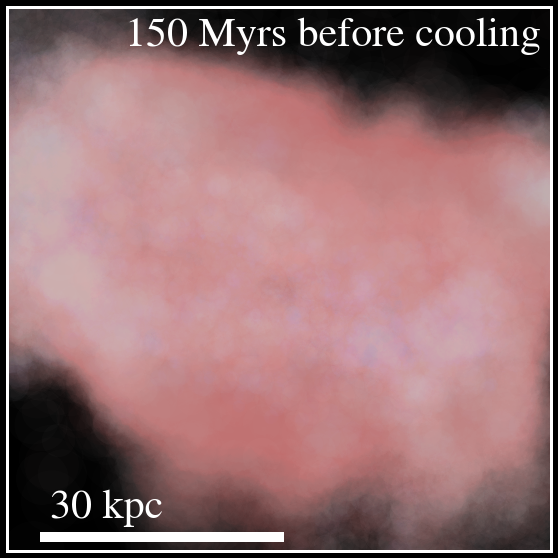

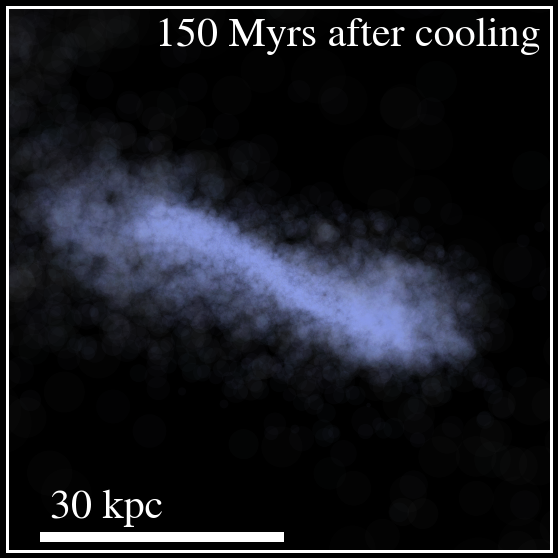

In [57]:
for i, d in enumerate( [ pre, post ] ):

    fig = plt.figure( figsize=(12,10), facecolor='k' )
    ax = plt.gca()

    # Point size
    lim = 0.13 * w.r_vir[snum]
    width_in_data = 2 * lim
    width_in_pixels = ax.get_window_extent().width
    pixels_to_points = fig.dpi / 72.
    scale = 10.
    radius = d['h'] * ( width_in_pixels / width_in_data ) * pixels_to_points * scale
    s = ( radius )**2.
    
    # Colors
    colors = cmap( norm( d['T'] ) )
    
    # Alpha
    if pm['variable_alpha']:
        column_den = d['M'] / d['h']**2.
        alpha = plt_colors.LogNorm( vmin=np.nanmin( column_den ), vmax=np.nanmax( column_den ) )( column_den ) * 0.065 * ( 50000 / w.n_particles)
        alpha[alpha>1.] = 1.
        alpha[alpha<0.] = 0.
        colors[:,3] = alpha
    else:
        colors[:,3] = 0.01
    
    # Plot itself
    ax.scatter(
        d['Rx'],
        d['Rz'],
        s = s,
        c = colors,
        edgecolors = 'none',
    )
    
    # Scale bar
    size = min( 30., 0.95 * lim )
    xy = ( -size, -0.95*lim )
    ax.plot(
        xy[0] + np.array([ 0., size ]),
        [ xy[1], xy[1] ],
        linewidth = 10,
        color = 'w',
    )
    ax.annotate(
        text = '{:.2g} kpc'.format( size ),
        xy = xy,
        xycoords = 'data',
        xytext = ( 5, 10 ),
        textcoords = 'offset points',
        va = 'bottom',
        ha = 'left',
        color = 'w',
        fontsize = 42,
    )
    
    # Plot label
    ax.annotate(
        text = prepost_labels[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        color = 'w',
        fontsize = 42,
    )
    
    # Limits
    ax.set_xlim( -lim, lim )
    ax.set_ylim( -lim, lim )
    ax.set_aspect( 'equal' )
    
    # Ticks
    plt.tick_params(
        which = 'both',
        left = False,
        labelleft = False,
        bottom = False,
        labelbottom = False,
    )
    
    # Change colors
    ax.set_facecolor( 'k' )
    plt.setp( ax.spines.values(), color='w' )
    [i.set_linewidth(3) for i in ax.spines.values()]
    
    plotting.save_fig(
        out_dir = os.path.join( pm['figure_dir'], 'projected' ),
        save_file = '{}_{}.png'.format( prepost_filetags[i], pm['variation'] ),
        fig = fig,
        resolution = 150.,
    )

### Movie Version

#### Get Data

In [58]:
# Mask Data
w.data_masker.clear_masks()
w.data_masker.mask_data( 'n_out', -1, 1 ) # Only include particles that have never left the main galaxy
w.data_masker.mask_data( 'PType', data_value=0 )

In [59]:
# Setup time steps
delta_t = 0.01
t_movie_after = np.arange( 0., 0.5 + delta_t, delta_t )
t_movie_before = -1. * np.arange( 0., 1.5 + delta_t, delta_t )[1:][::-1]
t_movie = np.concatenate( [ t_movie_before, t_movie_after ] )

In [60]:
ds = []
for i, t_frame in enumerate( tqdm.tqdm( t_movie ) ):
    
    t_frame_inds = np.argmin( np.abs( t_t1e5 - t_frame ), axis=1 )
    
    # Prepare to mask
    if len( w.data_masker.masks ) == 3:
        del w.data_masker.masks[2]
    
    # Mask data that's out of bounds
    out_of_bounds = t_frame_inds == 0
    out_of_bounds_mask = np.tile( out_of_bounds, ( w.n_snaps, 1 ) ).transpose()
    w.data_masker.mask_data( 'out_of_bounds', custom_mask=out_of_bounds_mask,  )
    
    # Base parameters
    d = {}
    for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T' ]:
        d[key] = w.get_selected_data( key, compress=False )[np.arange(w.n_particles),t_frame_inds].compressed()

    # Volume and smoothing length
    den_msunkpc3 = ( d['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
    d['Vol'] = d['M'] * unyt.Msun / den_msunkpc3
    d['h'] = ( 3. * d['Vol'] / 4. / np.pi )**(1./3.)

    ds.append( d )

100%|██████████| 201/201 [03:28<00:00,  1.04s/it]


#### Make Frames

In [85]:
# Frame and scalebar size objects
def round_down(num, divisor):
    return num - (num%divisor)
# The t_movie cut is set to be useless by default.
lim = np.max( [ np.nanpercentile( np.abs( ds[i]['Rx'] ), 80 ) for i in np.arange(len(ds))[t_movie >= -2] ] )

In [86]:
i_focused = 0

In [87]:
for i, d in enumerate( tqdm.tqdm( ds ) ):

    fig = plt.figure( figsize=(12,10), facecolor='k' )
    ax = plt.gca()

    # Point size
    width_in_data = 2 * lim
    width_in_pixels = ax.get_window_extent().width
    pixels_to_points = fig.dpi / 72.
    scale = 10.
    radius = d['h'] * ( width_in_pixels / width_in_data ) * pixels_to_points * scale
    s = ( radius )**2.
    
    # Colors
    colors = cmap( norm( d['T'] ) )
    
    # Alpha
    if pm['variable_alpha']:
        column_den = d['M'] / d['h']**2.
        alpha = plt_colors.LogNorm( vmin=np.nanmin( column_den ), vmax=np.nanmax( column_den ) )( column_den ) * 0.065 * ( 50000 / w.n_particles)
        alpha[alpha>1.] = 1.
        alpha[alpha<0.] = 0.
        colors[:,3] = alpha
    else:
        colors[:,3] = 0.01
    
    # Plot itself
    ax.scatter(
        d['Rx'],
        d['Rz'],
        s = s,
        c = colors,
        edgecolors = 'none',
    )
    
    # Scale bar
    size = round_down( min( 30., 0.95 * lim ), 10 )
    if np.isclose( size, 0. ):
        size = 10.
    xy = ( -size, -0.95*lim )
    ax.plot(
        xy[0] + np.array([ 0., size ]),
        [ xy[1], xy[1] ],
        linewidth = 10,
        color = 'w',
    )
    ax.annotate(
        text = '{:.2g} kpc'.format( size ),
        xy = xy,
        xycoords = 'data',
        xytext = ( 5, 10 ),
        textcoords = 'offset points',
        va = 'bottom',
        ha = 'left',
        color = 'w',
        fontsize = 42,
    )
    
    # Plot label
    ax.annotate(
        text = r'$t - t_{T = 10^5 {\rm K}} =$' + '{} Myrs'.format( int( t_movie[i]*1e3 ) ),
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        color = 'w',
        fontsize = 42,
    )
    
    # Limits
    ax.set_xlim( -lim, lim )
    ax.set_ylim( -lim, lim )
    ax.set_aspect( 'equal' )
    
    # Ticks
    plt.tick_params(
        which = 'both',
        left = False,
        labelleft = False,
        bottom = False,
        labelbottom = False,
    )
    
    # Change colors
    ax.set_facecolor( 'k' )
    plt.setp( ax.spines.values(), color='w' )
    [m.set_linewidth(3) for m in ax.spines.values()]
    
    plotting.save_fig(
        out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
        save_file = '{}_{:0>3d}.png'.format( pm['variation'], i ),
        fig = fig,
        resolution = 150.,
    )
    
    # Save movie focused on time of cooling
    if np.abs( t_movie[i] ) <= 0.150:
        plotting.save_fig(
            out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
            save_file = '{}_focused_{:0>3d}.png'.format( pm['variation'], i_focused ),
            fig = fig,
            resolution = 150.,
        )
        i_focused += 1
        
    
    plt.close()

  0%|          | 1/201 [00:02<09:29,  2.85s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_000.png


  1%|          | 2/201 [00:05<09:28,  2.86s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_001.png


  1%|▏         | 3/201 [00:08<09:26,  2.86s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_002.png


  2%|▏         | 4/201 [00:11<09:24,  2.87s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_003.png


  2%|▏         | 5/201 [00:14<09:23,  2.87s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_004.png


  3%|▎         | 6/201 [00:17<09:21,  2.88s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_005.png


  3%|▎         | 7/201 [00:20<09:18,  2.88s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_006.png


  4%|▍         | 8/201 [00:23<09:16,  2.88s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_007.png


  4%|▍         | 9/201 [00:26<09:52,  3.08s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_008.png


  5%|▍         | 10/201 [00:29<09:38,  3.03s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_009.png


  5%|▌         | 11/201 [00:32<09:28,  2.99s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_010.png


  6%|▌         | 12/201 [00:35<09:23,  2.98s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_011.png


  6%|▋         | 13/201 [00:38<09:17,  2.96s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_012.png


  7%|▋         | 14/201 [00:41<09:10,  2.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_013.png


  7%|▋         | 15/201 [00:44<09:08,  2.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_014.png


  8%|▊         | 16/201 [00:47<09:04,  2.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_015.png


  8%|▊         | 17/201 [00:49<09:01,  2.94s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_016.png


  9%|▉         | 18/201 [00:52<08:57,  2.94s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_017.png


  9%|▉         | 19/201 [00:55<08:55,  2.94s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_018.png


 10%|▉         | 20/201 [00:58<08:52,  2.94s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_019.png


 10%|█         | 21/201 [01:01<08:50,  2.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_020.png


 11%|█         | 22/201 [01:04<08:47,  2.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_021.png


 11%|█▏        | 23/201 [01:07<08:44,  2.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_022.png


 12%|█▏        | 24/201 [01:10<08:43,  2.96s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_023.png


 12%|█▏        | 25/201 [01:13<08:41,  2.96s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_024.png


 13%|█▎        | 26/201 [01:16<08:38,  2.96s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_025.png


 13%|█▎        | 27/201 [01:19<08:28,  2.92s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_026.png


 14%|█▍        | 28/201 [01:22<08:16,  2.87s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_027.png


 14%|█▍        | 29/201 [01:24<08:06,  2.83s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_028.png


 15%|█▍        | 30/201 [01:27<07:58,  2.80s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_029.png


 15%|█▌        | 31/201 [01:30<08:06,  2.86s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_030.png


 16%|█▌        | 32/201 [01:33<07:57,  2.83s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_031.png


 16%|█▋        | 33/201 [01:36<07:51,  2.80s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_032.png


 17%|█▋        | 34/201 [01:38<07:45,  2.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_033.png


 17%|█▋        | 35/201 [01:41<07:42,  2.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_034.png


 18%|█▊        | 36/201 [01:44<07:37,  2.77s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_035.png


 18%|█▊        | 37/201 [01:47<07:36,  2.78s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_036.png


 19%|█▉        | 38/201 [01:50<07:33,  2.78s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_037.png


 19%|█▉        | 39/201 [01:52<07:31,  2.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_038.png


 20%|█▉        | 40/201 [01:55<07:33,  2.82s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_039.png


 20%|██        | 41/201 [01:58<07:31,  2.82s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_040.png


 21%|██        | 42/201 [02:01<07:25,  2.80s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_041.png


 21%|██▏       | 43/201 [02:04<07:23,  2.81s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_042.png


 22%|██▏       | 44/201 [02:06<07:18,  2.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_043.png


 22%|██▏       | 45/201 [02:09<07:15,  2.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_044.png


 23%|██▎       | 46/201 [02:12<07:13,  2.80s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_045.png


 23%|██▎       | 47/201 [02:15<07:09,  2.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_046.png


 24%|██▍       | 48/201 [02:18<07:06,  2.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_047.png


 24%|██▍       | 49/201 [02:20<07:10,  2.83s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_048.png


 25%|██▍       | 50/201 [02:23<07:04,  2.81s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_049.png


 25%|██▌       | 51/201 [02:26<07:00,  2.81s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_050.png


 26%|██▌       | 52/201 [02:29<06:59,  2.81s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_051.png


 26%|██▋       | 53/201 [02:32<06:55,  2.81s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_052.png


 27%|██▋       | 54/201 [02:35<07:09,  2.92s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_053.png


 27%|██▋       | 55/201 [02:38<07:29,  3.08s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_054.png


 28%|██▊       | 56/201 [02:41<07:33,  3.13s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_055.png


 28%|██▊       | 57/201 [02:45<07:44,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_056.png


 29%|██▉       | 58/201 [02:48<07:40,  3.22s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_057.png


 29%|██▉       | 59/201 [02:51<07:39,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_058.png


 30%|██▉       | 60/201 [02:55<07:36,  3.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_059.png


 30%|███       | 61/201 [02:58<07:32,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_060.png


 31%|███       | 62/201 [03:01<07:29,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_061.png


 31%|███▏      | 63/201 [03:04<07:26,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_062.png


 32%|███▏      | 64/201 [03:08<07:21,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_063.png


 32%|███▏      | 65/201 [03:11<07:19,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_064.png


 33%|███▎      | 66/201 [03:14<07:16,  3.23s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_065.png


 33%|███▎      | 67/201 [03:17<07:13,  3.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_066.png


 34%|███▍      | 68/201 [03:21<07:10,  3.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_067.png


 34%|███▍      | 69/201 [03:24<07:07,  3.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_068.png


 35%|███▍      | 70/201 [03:27<07:03,  3.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_069.png


 35%|███▌      | 71/201 [03:30<07:01,  3.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_070.png


 36%|███▌      | 72/201 [03:34<06:58,  3.25s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_071.png


 36%|███▋      | 73/201 [03:37<06:55,  3.25s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_072.png


 37%|███▋      | 74/201 [03:40<06:54,  3.26s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_073.png


 37%|███▋      | 75/201 [03:43<06:53,  3.28s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_074.png


 38%|███▊      | 76/201 [03:47<06:54,  3.31s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_075.png


 38%|███▊      | 77/201 [03:50<06:54,  3.35s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_076.png


 39%|███▉      | 78/201 [03:54<06:51,  3.35s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_077.png


 39%|███▉      | 79/201 [03:57<06:47,  3.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_078.png


 40%|███▉      | 80/201 [04:00<06:44,  3.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_079.png


 40%|████      | 81/201 [04:04<06:40,  3.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_080.png


 41%|████      | 82/201 [04:07<06:36,  3.33s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_081.png


 41%|████▏     | 83/201 [04:10<06:34,  3.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_082.png


 42%|████▏     | 84/201 [04:14<06:32,  3.36s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_083.png


 42%|████▏     | 85/201 [04:17<06:29,  3.36s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_084.png


 43%|████▎     | 86/201 [04:21<06:35,  3.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_085.png


 43%|████▎     | 87/201 [04:24<06:29,  3.42s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_086.png


 44%|████▍     | 88/201 [04:27<06:26,  3.42s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_087.png


 44%|████▍     | 89/201 [04:31<06:22,  3.42s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_088.png


 45%|████▍     | 90/201 [04:34<06:19,  3.42s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_089.png


 45%|████▌     | 91/201 [04:38<06:17,  3.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_090.png


 46%|████▌     | 92/201 [04:41<06:14,  3.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_091.png


 46%|████▋     | 93/201 [04:45<06:12,  3.45s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_092.png


 47%|████▋     | 94/201 [04:48<06:10,  3.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_093.png


 47%|████▋     | 95/201 [04:52<06:08,  3.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_094.png


 48%|████▊     | 96/201 [04:55<06:04,  3.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_095.png


 48%|████▊     | 97/201 [04:59<06:02,  3.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_096.png


 49%|████▉     | 98/201 [05:02<06:00,  3.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_097.png


 49%|████▉     | 99/201 [05:06<05:57,  3.51s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_098.png


 50%|████▉     | 100/201 [05:09<05:56,  3.53s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_099.png


 50%|█████     | 101/201 [05:13<05:50,  3.51s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_100.png


 51%|█████     | 102/201 [05:16<05:46,  3.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_101.png


 51%|█████     | 103/201 [05:20<05:42,  3.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_102.png


 52%|█████▏    | 104/201 [05:23<05:40,  3.51s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_103.png


 52%|█████▏    | 105/201 [05:27<05:36,  3.51s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_104.png


 53%|█████▎    | 106/201 [05:30<05:32,  3.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_105.png


 53%|█████▎    | 107/201 [05:34<05:29,  3.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_106.png


 54%|█████▎    | 108/201 [05:37<05:24,  3.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_107.png


 54%|█████▍    | 109/201 [05:41<05:23,  3.52s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_108.png


 55%|█████▍    | 110/201 [05:44<05:24,  3.56s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_109.png


 55%|█████▌    | 111/201 [05:48<05:20,  3.57s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_110.png


 56%|█████▌    | 112/201 [05:52<05:16,  3.56s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_111.png


 56%|█████▌    | 113/201 [05:55<05:11,  3.54s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_112.png


 57%|█████▋    | 114/201 [05:59<05:08,  3.54s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_113.png


 57%|█████▋    | 115/201 [06:02<05:05,  3.55s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_114.png


 58%|█████▊    | 116/201 [06:06<05:03,  3.57s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_115.png


 58%|█████▊    | 117/201 [06:09<04:59,  3.57s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_116.png


 59%|█████▊    | 118/201 [06:13<04:56,  3.57s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_117.png


 59%|█████▉    | 119/201 [06:16<04:50,  3.54s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_118.png


 60%|█████▉    | 120/201 [06:20<04:45,  3.52s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_119.png


 60%|██████    | 121/201 [06:24<04:46,  3.59s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_120.png


 61%|██████    | 122/201 [06:27<04:43,  3.59s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_121.png


 61%|██████    | 123/201 [06:31<04:37,  3.56s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_122.png


 62%|██████▏   | 124/201 [06:34<04:33,  3.56s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_123.png


 62%|██████▏   | 125/201 [06:38<04:27,  3.52s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_124.png


 63%|██████▎   | 126/201 [06:41<04:21,  3.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_125.png


 63%|██████▎   | 127/201 [06:45<04:17,  3.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_126.png


 64%|██████▎   | 128/201 [06:48<04:13,  3.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_127.png


 64%|██████▍   | 129/201 [06:51<04:08,  3.45s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_128.png


 65%|██████▍   | 130/201 [06:55<04:01,  3.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_129.png


 65%|██████▌   | 131/201 [06:58<03:56,  3.38s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_130.png


 66%|██████▌   | 132/201 [07:01<03:50,  3.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_131.png


 66%|██████▌   | 133/201 [07:05<03:45,  3.31s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_132.png


 67%|██████▋   | 134/201 [07:08<03:39,  3.28s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_133.png


 67%|██████▋   | 135/201 [07:11<03:34,  3.25s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_134.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_135.png


 68%|██████▊   | 136/201 [07:17<04:29,  4.15s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_000.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_136.png


 68%|██████▊   | 137/201 [07:23<05:01,  4.71s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_001.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_137.png


 69%|██████▊   | 138/201 [07:29<05:21,  5.10s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_002.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_138.png


 69%|██████▉   | 139/201 [07:35<05:31,  5.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_003.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_139.png


 70%|██████▉   | 140/201 [07:41<05:42,  5.61s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_004.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_140.png


 70%|███████   | 141/201 [07:47<05:40,  5.67s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_005.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_141.png


 71%|███████   | 142/201 [07:53<05:37,  5.71s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_006.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_142.png


 71%|███████   | 143/201 [07:59<05:29,  5.68s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_007.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_143.png


 72%|███████▏  | 144/201 [08:04<05:16,  5.56s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_008.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_144.png


 72%|███████▏  | 145/201 [08:09<05:07,  5.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_009.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_145.png


 73%|███████▎  | 146/201 [08:14<04:50,  5.28s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_010.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_146.png


 73%|███████▎  | 147/201 [08:19<04:36,  5.12s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_011.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_147.png


 74%|███████▎  | 148/201 [08:23<04:13,  4.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_012.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_148.png


 74%|███████▍  | 149/201 [08:27<03:55,  4.52s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_013.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_149.png


 75%|███████▍  | 150/201 [08:29<03:23,  3.98s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_014.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_150.png


 75%|███████▌  | 151/201 [08:32<03:00,  3.60s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_015.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_151.png


 76%|███████▌  | 152/201 [08:35<02:42,  3.32s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_016.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_152.png


 76%|███████▌  | 153/201 [08:37<02:18,  2.88s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_017.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_153.png


 77%|███████▋  | 154/201 [08:38<02:00,  2.57s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_018.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_154.png


 77%|███████▋  | 155/201 [08:40<01:45,  2.30s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_019.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_155.png


 78%|███████▊  | 156/201 [08:42<01:34,  2.10s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_020.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_156.png


 78%|███████▊  | 157/201 [08:43<01:24,  1.92s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_021.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_157.png


 79%|███████▊  | 158/201 [08:45<01:22,  1.91s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_022.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_158.png


 79%|███████▉  | 159/201 [08:47<01:14,  1.77s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_023.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_159.png


 80%|███████▉  | 160/201 [08:48<01:08,  1.67s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_024.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_160.png


 80%|████████  | 161/201 [08:49<01:03,  1.59s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_025.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_161.png


 81%|████████  | 162/201 [08:51<00:59,  1.51s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_026.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_162.png


 81%|████████  | 163/201 [08:52<00:55,  1.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_027.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_163.png


 82%|████████▏ | 164/201 [08:53<00:51,  1.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_028.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_164.png


 82%|████████▏ | 165/201 [08:55<00:48,  1.36s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_029.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_165.png


 83%|████████▎ | 166/201 [08:56<00:46,  1.32s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_030.png


 83%|████████▎ | 167/201 [08:56<00:37,  1.11s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_166.png


 84%|████████▎ | 168/201 [08:57<00:31,  1.04it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_167.png


 84%|████████▍ | 169/201 [08:58<00:27,  1.17it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_168.png


 85%|████████▍ | 170/201 [08:58<00:24,  1.28it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_169.png


 85%|████████▌ | 171/201 [08:59<00:21,  1.40it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_170.png


 86%|████████▌ | 172/201 [08:59<00:19,  1.48it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_171.png


 86%|████████▌ | 173/201 [09:00<00:17,  1.56it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_172.png


 87%|████████▋ | 174/201 [09:00<00:16,  1.62it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_173.png


 87%|████████▋ | 175/201 [09:01<00:15,  1.68it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_174.png


 88%|████████▊ | 176/201 [09:02<00:14,  1.74it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_175.png


 88%|████████▊ | 177/201 [09:02<00:13,  1.78it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_176.png


 89%|████████▊ | 178/201 [09:03<00:12,  1.84it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_177.png


 89%|████████▉ | 179/201 [09:03<00:11,  1.87it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_178.png


 90%|████████▉ | 180/201 [09:04<00:10,  1.92it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_179.png


 90%|█████████ | 181/201 [09:04<00:10,  1.96it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_180.png


 91%|█████████ | 182/201 [09:05<00:09,  2.00it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_181.png


 91%|█████████ | 183/201 [09:05<00:08,  2.05it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_182.png


 92%|█████████▏| 184/201 [09:05<00:08,  2.09it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_183.png


 92%|█████████▏| 185/201 [09:06<00:07,  2.16it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_184.png


 93%|█████████▎| 186/201 [09:06<00:06,  2.22it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_185.png


 93%|█████████▎| 187/201 [09:07<00:06,  2.28it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_186.png


 94%|█████████▎| 188/201 [09:07<00:05,  2.34it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_187.png


 94%|█████████▍| 189/201 [09:08<00:05,  2.39it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_188.png


 95%|█████████▍| 190/201 [09:08<00:04,  2.43it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_189.png


 95%|█████████▌| 191/201 [09:08<00:04,  2.47it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_190.png


 96%|█████████▌| 192/201 [09:09<00:03,  2.52it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_191.png


 96%|█████████▌| 193/201 [09:09<00:03,  2.57it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_192.png


 97%|█████████▋| 194/201 [09:09<00:02,  2.62it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_193.png


 97%|█████████▋| 195/201 [09:10<00:02,  2.67it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_194.png


 98%|█████████▊| 196/201 [09:10<00:01,  2.72it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_195.png


 98%|█████████▊| 197/201 [09:10<00:01,  2.77it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_196.png


 99%|█████████▊| 198/201 [09:11<00:01,  2.82it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_197.png


 99%|█████████▉| 199/201 [09:11<00:00,  2.87it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_198.png


100%|█████████▉| 200/201 [09:12<00:00,  2.80it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_199.png


100%|██████████| 201/201 [09:12<00:00,  2.75s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_200.png


#### Flat Color Frames

In [74]:
i_focused = 0

In [77]:
for i, d in enumerate( tqdm.tqdm( ds ) ):

    fig = plt.figure( figsize=(12,10), facecolor='k' )
    ax = plt.gca()

    # Point size
    width_in_data = 2 * lim
    width_in_pixels = ax.get_window_extent().width
    pixels_to_points = fig.dpi / 72.
    scale = 10.
    radius = d['h'] * ( width_in_pixels / width_in_data ) * pixels_to_points * scale
    s = ( radius )**2.
    
    # Colors
    colors = np.zeros( ( d['T'].size, 4 ) )
    colors[:,:3] = np.array([ [ 1., 1., 1.], ] * d['T'].size )
    
    # Alpha
    if pm['variable_alpha']:
        column_den = d['M'] / d['h']**2.
        alpha = plt_colors.LogNorm( vmin=np.nanmin( column_den ), vmax=np.nanmax( column_den ) )( column_den ) * 0.065 * ( 50000 / w.n_particles)
        alpha[alpha>1.] = 1.
        alpha[alpha<0.] = 0.
        colors[:,3] = alpha
    else:
        colors[:,3] = 0.01
    
    # Plot itself
    ax.scatter(
        d['Rx'],
        d['Rz'],
        s = s,
        c = colors,
        edgecolors = 'none',
    )
    
    # Scale bar
    size = round_down( min( 30., 0.95 * lim ), 10 )
    if np.isclose( size, 0. ):
        size = 10.
    xy = ( -size, -0.95*lim )
    ax.plot(
        xy[0] + np.array([ 0., size ]),
        [ xy[1], xy[1] ],
        linewidth = 10,
        color = 'w',
    )
    ax.annotate(
        text = '{:.2g} kpc'.format( size ),
        xy = xy,
        xycoords = 'data',
        xytext = ( 5, 10 ),
        textcoords = 'offset points',
        va = 'bottom',
        ha = 'left',
        color = 'w',
        fontsize = 42,
    )
    
    # Plot label
    ax.annotate(
        text = r'$t - t_{T = 10^5 {\rm K}} =$' + '{} Myrs'.format( int( t_movie[i]*1e3 ) ),
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        color = 'w',
        fontsize = 42,
    )
    
    # Limits
    ax.set_xlim( -lim, lim )
    ax.set_ylim( -lim, lim )
    ax.set_aspect( 'equal' )
    
    # Ticks
    plt.tick_params(
        which = 'both',
        left = False,
        labelleft = False,
        bottom = False,
        labelbottom = False,
    )
    
    # Change colors
    ax.set_facecolor( 'k' )
    plt.setp( ax.spines.values(), color='w' )
    [m.set_linewidth(3) for m in ax.spines.values()]
    
    plotting.save_fig(
        out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
        save_file = '{}_colden_{:0>3d}.png'.format( pm['variation'], i ),
        fig = fig,
        resolution = 150.,
    )
    
    # Save movie focused on time of cooling
    if np.abs( t_movie[i] ) <= 0.150:
        plotting.save_fig(
            out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
            save_file = '{}_focused_colden_{:0>3d}.png'.format( pm['variation'], i_focused ),
            fig = fig,
            resolution = 150.,
        )
        i_focused += 1
        
    
    plt.close()

  0%|          | 1/201 [00:02<08:13,  2.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_000.png


  1%|          | 2/201 [00:04<08:13,  2.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_001.png


  1%|▏         | 3/201 [00:07<08:12,  2.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_002.png


  2%|▏         | 4/201 [00:10<08:12,  2.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_003.png


  2%|▏         | 5/201 [00:12<08:07,  2.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_004.png


  3%|▎         | 6/201 [00:14<08:06,  2.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_005.png


  3%|▎         | 7/201 [00:17<08:04,  2.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_006.png


  4%|▍         | 8/201 [00:19<08:00,  2.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_007.png


  4%|▍         | 9/201 [00:22<07:57,  2.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_008.png


  5%|▍         | 10/201 [00:24<07:55,  2.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_009.png


  5%|▌         | 11/201 [00:27<07:52,  2.49s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_010.png


  6%|▌         | 12/201 [00:30<07:58,  2.53s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_011.png


  6%|▋         | 13/201 [00:32<07:52,  2.51s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_012.png


  7%|▋         | 14/201 [00:34<07:47,  2.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_013.png


  7%|▋         | 15/201 [00:37<07:41,  2.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_014.png


  8%|▊         | 16/201 [00:39<07:36,  2.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_015.png


  8%|▊         | 17/201 [00:42<07:32,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_016.png


  9%|▉         | 18/201 [00:44<07:29,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_017.png


  9%|▉         | 19/201 [00:47<07:26,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_018.png


 10%|▉         | 20/201 [00:49<07:22,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_019.png


 10%|█         | 21/201 [00:52<07:21,  2.45s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_020.png


 11%|█         | 22/201 [00:54<07:16,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_021.png


 11%|█▏        | 23/201 [00:56<07:15,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_022.png


 12%|█▏        | 24/201 [00:59<07:12,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_023.png


 12%|█▏        | 25/201 [01:01<07:09,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_024.png


 13%|█▎        | 26/201 [01:04<07:07,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_025.png


 13%|█▎        | 27/201 [01:06<07:05,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_026.png


 14%|█▍        | 28/201 [01:09<07:02,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_027.png


 14%|█▍        | 29/201 [01:11<06:58,  2.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_028.png


 15%|█▍        | 30/201 [01:13<06:55,  2.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_029.png


 15%|█▌        | 31/201 [01:16<06:52,  2.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_030.png


 16%|█▌        | 32/201 [01:18<06:48,  2.42s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_031.png


 16%|█▋        | 33/201 [01:21<06:45,  2.41s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_032.png


 17%|█▋        | 34/201 [01:23<06:49,  2.45s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_033.png


 17%|█▋        | 35/201 [01:26<06:42,  2.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_034.png


 18%|█▊        | 36/201 [01:28<06:37,  2.41s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_035.png


 18%|█▊        | 37/201 [01:30<06:33,  2.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_036.png


 19%|█▉        | 38/201 [01:33<06:30,  2.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_037.png


 19%|█▉        | 39/201 [01:35<06:28,  2.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_038.png


 20%|█▉        | 40/201 [01:38<06:24,  2.39s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_039.png


 20%|██        | 41/201 [01:40<06:21,  2.38s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_040.png


 21%|██        | 42/201 [01:42<06:18,  2.38s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_041.png


 21%|██▏       | 43/201 [01:45<06:13,  2.37s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_042.png


 22%|██▏       | 44/201 [01:47<06:10,  2.36s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_043.png


 22%|██▏       | 45/201 [01:49<06:09,  2.37s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_044.png


 23%|██▎       | 46/201 [01:52<06:05,  2.36s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_045.png


 23%|██▎       | 47/201 [01:54<06:02,  2.35s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_046.png


 24%|██▍       | 48/201 [01:56<05:59,  2.35s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_047.png


 24%|██▍       | 49/201 [01:59<05:55,  2.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_048.png


 25%|██▍       | 50/201 [02:01<05:55,  2.35s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_049.png


 25%|██▌       | 51/201 [02:03<05:53,  2.36s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_050.png


 26%|██▌       | 52/201 [02:06<05:56,  2.39s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_051.png


 26%|██▋       | 53/201 [02:09<06:05,  2.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_052.png


 27%|██▋       | 54/201 [02:11<06:02,  2.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_053.png


 27%|██▋       | 55/201 [02:13<06:00,  2.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_054.png


 28%|██▊       | 56/201 [02:16<05:56,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_055.png


 28%|██▊       | 57/201 [02:18<05:54,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_056.png


 29%|██▉       | 58/201 [02:21<05:51,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_057.png


 29%|██▉       | 59/201 [02:23<05:49,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_058.png


 30%|██▉       | 60/201 [02:26<05:55,  2.52s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_059.png


 30%|███       | 61/201 [02:28<05:50,  2.51s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_060.png


 31%|███       | 62/201 [02:31<05:44,  2.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_061.png


 31%|███▏      | 63/201 [02:33<05:40,  2.47s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_062.png


 32%|███▏      | 64/201 [02:36<05:36,  2.46s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_063.png


 32%|███▏      | 65/201 [02:38<05:31,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_064.png


 33%|███▎      | 66/201 [02:41<05:29,  2.44s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_065.png


 33%|███▎      | 67/201 [02:43<05:26,  2.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_066.png


 34%|███▍      | 68/201 [02:45<05:22,  2.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_067.png


 34%|███▍      | 69/201 [02:48<05:18,  2.42s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_068.png


 35%|███▍      | 70/201 [02:50<05:15,  2.41s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_069.png


 35%|███▌      | 71/201 [02:53<05:12,  2.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_070.png


 36%|███▌      | 72/201 [02:55<05:10,  2.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_071.png


 36%|███▋      | 73/201 [02:57<05:06,  2.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_072.png


 37%|███▋      | 74/201 [03:00<05:04,  2.39s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_073.png


 37%|███▋      | 75/201 [03:02<05:00,  2.39s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_074.png


 38%|███▊      | 76/201 [03:04<04:57,  2.38s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_075.png


 38%|███▊      | 77/201 [03:07<04:54,  2.37s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_076.png


 39%|███▉      | 78/201 [03:09<04:51,  2.37s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_077.png


 39%|███▉      | 79/201 [03:12<04:47,  2.36s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_078.png


 40%|███▉      | 80/201 [03:14<04:44,  2.35s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_079.png


 40%|████      | 81/201 [03:16<04:40,  2.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_080.png


 41%|████      | 82/201 [03:18<04:36,  2.33s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_081.png


 41%|████▏     | 83/201 [03:21<04:33,  2.32s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_082.png


 42%|████▏     | 84/201 [03:23<04:30,  2.31s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_083.png


 42%|████▏     | 85/201 [03:25<04:26,  2.30s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_084.png


 43%|████▎     | 86/201 [03:28<04:22,  2.28s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_085.png


 43%|████▎     | 87/201 [03:30<04:20,  2.29s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_086.png


 44%|████▍     | 88/201 [03:32<04:17,  2.28s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_087.png


 44%|████▍     | 89/201 [03:34<04:08,  2.22s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_088.png


 45%|████▍     | 90/201 [03:37<04:13,  2.28s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_089.png


 45%|████▌     | 91/201 [03:39<04:08,  2.26s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_090.png


 46%|████▌     | 92/201 [03:41<04:04,  2.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_091.png


 46%|████▋     | 93/201 [03:43<04:01,  2.24s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_092.png


 47%|████▋     | 94/201 [03:45<03:57,  2.22s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_093.png


 47%|████▋     | 95/201 [03:48<03:54,  2.21s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_094.png


 48%|████▊     | 96/201 [03:50<03:49,  2.19s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_095.png


 48%|████▊     | 97/201 [03:52<03:45,  2.17s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_096.png


 49%|████▉     | 98/201 [03:54<03:38,  2.13s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_097.png


 49%|████▉     | 99/201 [03:56<03:35,  2.11s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_098.png


 50%|████▉     | 100/201 [03:58<03:31,  2.09s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_099.png


 50%|█████     | 101/201 [04:00<03:28,  2.08s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_100.png


 51%|█████     | 102/201 [04:02<03:23,  2.05s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_101.png


 51%|█████     | 103/201 [04:04<03:20,  2.05s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_102.png


 52%|█████▏    | 104/201 [04:06<03:16,  2.02s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_103.png


 52%|█████▏    | 105/201 [04:08<03:11,  2.00s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_104.png


 53%|█████▎    | 106/201 [04:10<03:07,  1.98s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_105.png


 53%|█████▎    | 107/201 [04:12<03:03,  1.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_106.png


 54%|█████▎    | 108/201 [04:14<02:58,  1.92s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_107.png


 54%|█████▍    | 109/201 [04:16<02:54,  1.90s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_108.png


 55%|█████▍    | 110/201 [04:17<02:50,  1.88s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_109.png


 55%|█████▌    | 111/201 [04:19<02:47,  1.86s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_110.png


 56%|█████▌    | 112/201 [04:21<02:42,  1.83s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_111.png


 56%|█████▌    | 113/201 [04:23<02:39,  1.81s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_112.png


 57%|█████▋    | 114/201 [04:24<02:35,  1.79s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_113.png


 57%|█████▋    | 115/201 [04:26<02:32,  1.78s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_114.png


 58%|█████▊    | 116/201 [04:28<02:29,  1.76s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_115.png


 58%|█████▊    | 117/201 [04:30<02:26,  1.74s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_116.png


 59%|█████▊    | 118/201 [04:31<02:22,  1.72s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_117.png


 59%|█████▉    | 119/201 [04:33<02:18,  1.69s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_118.png


 60%|█████▉    | 120/201 [04:35<02:15,  1.67s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_119.png


 60%|██████    | 121/201 [04:36<02:11,  1.65s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_120.png


 61%|██████    | 122/201 [04:38<02:08,  1.62s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_121.png


 61%|██████    | 123/201 [04:39<02:04,  1.60s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_122.png


 62%|██████▏   | 124/201 [04:41<02:01,  1.58s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_123.png


 62%|██████▏   | 125/201 [04:43<02:05,  1.65s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_124.png


 63%|██████▎   | 126/201 [04:44<01:59,  1.59s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_125.png


 63%|██████▎   | 127/201 [04:45<01:54,  1.55s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_126.png


 64%|██████▎   | 128/201 [04:47<01:49,  1.50s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_127.png


 64%|██████▍   | 129/201 [04:48<01:46,  1.48s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_128.png


 65%|██████▍   | 130/201 [04:50<01:43,  1.45s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_129.png


 65%|██████▌   | 131/201 [04:51<01:40,  1.43s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_130.png


 66%|██████▌   | 132/201 [04:52<01:36,  1.40s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_131.png


 66%|██████▌   | 133/201 [04:54<01:33,  1.37s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_132.png


 67%|██████▋   | 134/201 [04:55<01:30,  1.35s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_133.png


 67%|██████▋   | 135/201 [04:56<01:28,  1.34s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_134.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_135.png


 68%|██████▊   | 136/201 [04:59<01:49,  1.68s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_000.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_136.png


 68%|██████▊   | 137/201 [05:01<02:01,  1.89s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_001.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_137.png


 69%|██████▊   | 138/201 [05:04<02:09,  2.05s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_002.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_138.png


 69%|██████▉   | 139/201 [05:06<02:11,  2.12s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_003.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_139.png


 70%|██████▉   | 140/201 [05:08<02:12,  2.17s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_004.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_140.png


 70%|███████   | 141/201 [05:10<02:10,  2.18s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_005.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_141.png


 71%|███████   | 142/201 [05:13<02:08,  2.18s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_006.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_142.png


 71%|███████   | 143/201 [05:15<02:06,  2.18s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_007.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_143.png


 72%|███████▏  | 144/201 [05:17<02:02,  2.15s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_008.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_144.png


 72%|███████▏  | 145/201 [05:19<01:59,  2.14s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_009.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_145.png


 73%|███████▎  | 146/201 [05:21<01:54,  2.08s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_010.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_146.png


 73%|███████▎  | 147/201 [05:23<01:50,  2.04s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_011.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_147.png


 74%|███████▎  | 148/201 [05:25<01:43,  1.95s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_012.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_148.png


 74%|███████▍  | 149/201 [05:26<01:38,  1.89s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_013.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_149.png


 75%|███████▍  | 150/201 [05:28<01:28,  1.74s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_014.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_150.png


 75%|███████▌  | 151/201 [05:29<01:21,  1.62s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_015.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_151.png


 76%|███████▌  | 152/201 [05:30<01:15,  1.55s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_016.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_152.png


 76%|███████▌  | 153/201 [05:31<01:06,  1.38s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_017.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_153.png


 77%|███████▋  | 154/201 [05:32<00:59,  1.26s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_018.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_154.png


 77%|███████▋  | 155/201 [05:33<00:52,  1.15s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_019.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_155.png


 78%|███████▊  | 156/201 [05:34<00:48,  1.07s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_020.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_156.png


 78%|███████▊  | 157/201 [05:35<00:44,  1.01s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_021.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_157.png


 79%|███████▊  | 158/201 [05:36<00:41,  1.04it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_022.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_158.png


 79%|███████▉  | 159/201 [05:37<00:38,  1.08it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_023.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_159.png


 80%|███████▉  | 160/201 [05:38<00:36,  1.12it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_024.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_160.png


 80%|████████  | 161/201 [05:38<00:34,  1.15it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_025.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_161.png


 81%|████████  | 162/201 [05:39<00:33,  1.18it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_026.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_162.png


 81%|████████  | 163/201 [05:40<00:31,  1.21it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_027.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_163.png


 82%|████████▏ | 164/201 [05:41<00:34,  1.08it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_028.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_164.png


 82%|████████▏ | 165/201 [05:42<00:31,  1.14it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_029.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_165.png


 83%|████████▎ | 166/201 [05:43<00:29,  1.19it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_colden_030.png


 83%|████████▎ | 167/201 [05:43<00:24,  1.41it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_166.png


 84%|████████▎ | 168/201 [05:43<00:20,  1.63it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_167.png


 84%|████████▍ | 169/201 [05:44<00:17,  1.83it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_168.png


 85%|████████▍ | 170/201 [05:44<00:15,  2.00it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_169.png


 85%|████████▌ | 171/201 [05:45<00:13,  2.15it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_170.png


 86%|████████▌ | 172/201 [05:45<00:12,  2.27it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_171.png


 86%|████████▌ | 173/201 [05:45<00:11,  2.39it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_172.png


 87%|████████▋ | 174/201 [05:46<00:10,  2.47it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_173.png


 87%|████████▋ | 175/201 [05:46<00:10,  2.56it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_174.png


 88%|████████▊ | 176/201 [05:46<00:09,  2.62it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_175.png


 88%|████████▊ | 177/201 [05:47<00:08,  2.68it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_176.png


 89%|████████▊ | 178/201 [05:47<00:08,  2.73it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_177.png


 89%|████████▉ | 179/201 [05:47<00:07,  2.78it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_178.png


 90%|████████▉ | 180/201 [05:48<00:07,  2.84it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_179.png


 90%|█████████ | 181/201 [05:48<00:06,  2.88it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_180.png


 91%|█████████ | 182/201 [05:48<00:06,  2.92it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_181.png


 91%|█████████ | 183/201 [05:49<00:06,  2.95it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_182.png


 92%|█████████▏| 184/201 [05:49<00:05,  2.99it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_183.png


 92%|█████████▏| 185/201 [05:49<00:05,  3.03it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_184.png


 93%|█████████▎| 186/201 [05:50<00:04,  3.07it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_185.png


 93%|█████████▎| 187/201 [05:50<00:04,  3.13it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_186.png


 94%|█████████▎| 188/201 [05:50<00:04,  3.15it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_187.png


 94%|█████████▍| 189/201 [05:51<00:03,  3.20it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_188.png


 95%|█████████▍| 190/201 [05:51<00:03,  3.24it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_189.png


 95%|█████████▌| 191/201 [05:51<00:03,  3.28it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_190.png


 96%|█████████▌| 192/201 [05:52<00:02,  3.31it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_191.png


 96%|█████████▌| 193/201 [05:52<00:02,  3.34it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_192.png


 97%|█████████▋| 194/201 [05:52<00:02,  3.37it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_193.png


 97%|█████████▋| 195/201 [05:52<00:01,  3.41it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_194.png


 98%|█████████▊| 196/201 [05:53<00:01,  3.45it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_195.png


 98%|█████████▊| 197/201 [05:53<00:01,  3.49it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_196.png


 99%|█████████▊| 198/201 [05:53<00:00,  3.54it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_197.png


 99%|█████████▉| 199/201 [05:54<00:00,  3.57it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_198.png


100%|█████████▉| 200/201 [05:54<00:00,  3.60it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_199.png


100%|██████████| 201/201 [05:54<00:00,  1.76s/it]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_colden_200.png
